In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import split, col
import os
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [2]:
sc = SparkContext(master="local[4]")
sqlContext = SQLContext(sc)

In [22]:
! [ -e /Elec_Data/AEP_houly ] && echo "File exist" || echo "File does not exist"

File does not exist


In [16]:
!FILE=Elec_Data/AEP_houly.csv
!if test -f "$FILE"; then
!    echo "$FILE exists."

/bin/sh: 1: Syntax error: end of file unexpected
 exists.


In [17]:
#!wget 'https://www.kaggle.com/robikscube/hourly-energy-consumption/download/AEP_hourly.csv.zip' -P Elec_Data/
#!unzip AEP_hourly.csv.zip -d Elec_Data
#!rm -f Elec_Data/AEP_houly.csv.zip

In [3]:
#load file data into sqlcontext dataframe
#fix schema for MW-per hr field to double

df_orig_1 = sqlContext.read.format("csv").option("header", "true").load("Elec_Data/AEP_hourly.csv")
print("Schema for original dataframe formed from data file:")
df_orig_1.printSchema()
df_orig_2 = df_orig_1.withColumn('AEP_MW', df_orig_1['AEP_MW'].cast('double'))
print("Fixed schema for original dataframe:")
df_orig_2.printSchema()
df_orig_2.show()

Schema for original dataframe formed from data file:
root
 |-- Datetime: string (nullable = true)
 |-- AEP_MW: string (nullable = true)

Fixed schema for original dataframe:
root
 |-- Datetime: string (nullable = true)
 |-- AEP_MW: double (nullable = true)

+-------------------+-------+
|           Datetime| AEP_MW|
+-------------------+-------+
|2004-12-31 01:00:00|13478.0|
|2004-12-31 02:00:00|12865.0|
|2004-12-31 03:00:00|12577.0|
|2004-12-31 04:00:00|12517.0|
|2004-12-31 05:00:00|12670.0|
|2004-12-31 06:00:00|13038.0|
|2004-12-31 07:00:00|13692.0|
|2004-12-31 08:00:00|14297.0|
|2004-12-31 09:00:00|14719.0|
|2004-12-31 10:00:00|14941.0|
|2004-12-31 11:00:00|15184.0|
|2004-12-31 12:00:00|15009.0|
|2004-12-31 13:00:00|14808.0|
|2004-12-31 14:00:00|14522.0|
|2004-12-31 15:00:00|14349.0|
|2004-12-31 16:00:00|14107.0|
|2004-12-31 17:00:00|14410.0|
|2004-12-31 18:00:00|15174.0|
|2004-12-31 19:00:00|15261.0|
|2004-12-31 20:00:00|14774.0|
+-------------------+-------+
only showing top 20 ro

In [5]:
#split data frame to have date elements in separate columns

split_col = split(df_orig_2['Datetime'], '-')
df_orig_2 = df_orig_2.withColumn('year', split_col.getItem(0))
df_orig_2 = df_orig_2.withColumn('month', split_col.getItem(1))
df_orig_2 = df_orig_2.withColumn('daytime', split_col.getItem(2))
split_last_col = split(df_orig_2['daytime'], ' ')
df_orig_2 = df_orig_2.withColumn('day', split_last_col.getItem(0))
df_orig_2 = df_orig_2.withColumn('hour', split_last_col.getItem(1)[0:2])
df_orig_2 = df_orig_2.drop("Datetime")
df_orig_2 = df_orig_2.drop("daytime")

In [6]:
df_orig_2.show()
df_orig_2.count()

+-------+----+-----+---+----+
| AEP_MW|year|month|day|hour|
+-------+----+-----+---+----+
|13478.0|2004|   12| 31|  01|
|12865.0|2004|   12| 31|  02|
|12577.0|2004|   12| 31|  03|
|12517.0|2004|   12| 31|  04|
|12670.0|2004|   12| 31|  05|
|13038.0|2004|   12| 31|  06|
|13692.0|2004|   12| 31|  07|
|14297.0|2004|   12| 31|  08|
|14719.0|2004|   12| 31|  09|
|14941.0|2004|   12| 31|  10|
|15184.0|2004|   12| 31|  11|
|15009.0|2004|   12| 31|  12|
|14808.0|2004|   12| 31|  13|
|14522.0|2004|   12| 31|  14|
|14349.0|2004|   12| 31|  15|
|14107.0|2004|   12| 31|  16|
|14410.0|2004|   12| 31|  17|
|15174.0|2004|   12| 31|  18|
|15261.0|2004|   12| 31|  19|
|14774.0|2004|   12| 31|  20|
+-------+----+-----+---+----+
only showing top 20 rows



121273

In [7]:
sqlContext.registerDataFrameAsTable(df_orig_2,'elec_data')
query="""
SELECT year ,COUNT(AEP_MW) AS count 
FROM elec_data 
GROUP BY year 
ORDER BY year
"""
sqlContext.sql(query).show()

+----+-----+
|year|count|
+----+-----+
|2004| 2206|
|2005| 8758|
|2006| 8758|
|2007| 8758|
|2008| 8782|
|2009| 8758|
|2010| 8757|
|2011| 8758|
|2012| 8781|
|2013| 8758|
|2014| 8759|
|2015| 8760|
|2016| 8784|
|2017| 8760|
|2018| 5136|
+----+-----+



In [8]:
query="""
SELECT  AEP_MW, day, month, year, hour 
FROM elec_data
 WHERE
(year>=2005 and year<=2017)
"""

df_test_nan=sqlContext.sql(query)
rdd_test_nan=df_test_nan.rdd.map(lambda row: np.float(row['AEP_MW']))
UnDef=rdd_test_nan.map(lambda row:np.int(np.isnan(row))).sum()
print(UnDef)

0


In [9]:
query="""
SELECT  month, day , year, count(AEP_MW) as count_meas
FROM elec_data
WHERE
year>=2005 and year<=2017
GROUP BY month, day, year
ORDER BY count_meas ASC

"""
df_mix_days=sqlContext.sql(query)
df_mix_days.show(26)
sqlContext.registerDataFrameAsTable(df_mix_days,'mix_days_data')

+-----+---+----+----------+
|month|day|year|count_meas|
+-----+---+----+----------+
|   11| 04|2012|        23|
|   03| 14|2010|        23|
|   03| 13|2016|        23|
|   04| 03|2005|        23|
|   03| 11|2014|        23|
|   12| 10|2010|        23|
|   11| 02|2008|        23|
|   11| 06|2011|        23|
|   03| 08|2015|        23|
|   10| 29|2006|        23|
|   03| 10|2013|        23|
|   11| 07|2010|        23|
|   11| 01|2009|        23|
|   03| 09|2008|        23|
|   03| 11|2012|        23|
|   03| 11|2007|        23|
|   12| 06|2012|        23|
|   11| 03|2013|        23|
|   03| 12|2017|        23|
|   03| 09|2014|        23|
|   03| 08|2009|        23|
|   03| 13|2011|        23|
|   04| 02|2006|        23|
|   11| 04|2007|        23|
|   10| 30|2005|        23|
|   01| 11|2010|        24|
+-----+---+----+----------+
only showing top 26 rows



In [10]:
df_hourly_pre=df_orig_2.join(df_mix_days, on=['month', 'day','year'], how='inner')
df_hourly_pre.show()
sqlContext.registerDataFrameAsTable(df_hourly_pre,'hourly_data_daily_count')
df_hourly_pre.count()

+-----+---+----+-------+----+----------+
|month|day|year| AEP_MW|hour|count_meas|
+-----+---+----+-------+----+----------+
|   01| 01|2005|12892.0|  00|        24|
|   12| 31|2005|14254.0|  01|        24|
|   12| 31|2005|13761.0|  02|        24|
|   12| 31|2005|13445.0|  03|        24|
|   12| 31|2005|13306.0|  04|        24|
|   12| 31|2005|13219.0|  05|        24|
|   12| 31|2005|13433.0|  06|        24|
|   12| 31|2005|13740.0|  07|        24|
|   12| 31|2005|14354.0|  08|        24|
|   12| 31|2005|14772.0|  09|        24|
|   12| 31|2005|15354.0|  10|        24|
|   12| 31|2005|15688.0|  11|        24|
|   12| 31|2005|15650.0|  12|        24|
|   12| 31|2005|15489.0|  13|        24|
|   12| 31|2005|15257.0|  14|        24|
|   12| 31|2005|15239.0|  15|        24|
|   12| 31|2005|15216.0|  16|        24|
|   12| 31|2005|15469.0|  17|        24|
|   12| 31|2005|16400.0|  18|        24|
|   12| 31|2005|16462.0|  19|        24|
+-----+---+----+-------+----+----------+
only showing top

113931

In [13]:
query="""
SELECT  * 
FROM hourly_data_daily_count
WHERE count_meas==24
ORDER BY year, month, day, hour
"""

df_full_data_hourly=sqlContext.sql(query)
sqlContext.registerDataFrameAsTable(df_full_data_hourly,'used_data_hourly')


In [14]:
query="""
SELECT  AVG(AEP_MW) AS avg_MW_per_hr , hour 
FROM used_data_hourly
GROUP BY hour
ORDER BY hour
"""

df_full_days=sqlContext.sql(query)
df_full_days.show(24)
rdd_hour_avg_pre=df_full_days.rdd.map(lambda row: np.float(row['avg_MW_per_hr']))
hour_avg_array=np.array(rdd_hour_avg_pre.collect())

#rdd_hour_avg = np.concatenate(np.array(rdd_hour_avg_pre).ravel().tolist()

+------------------+----+
|     avg_MW_per_hr|hour|
+------------------+----+
| 14671.88874761602|  00|
| 13904.05785123967|  01|
|13439.855054036872|  02|
|13188.196863742318|  03|
|  13097.7819453274|  04|
|13242.179275270184|  05|
|13806.066539521085|  06|
|14792.432930705658|  07|
|15490.261284170376|  08|
|15836.711591438865|  09|
|16103.594193685103|  10|
|16333.905700360247|  11|
|16432.198770926043|  12|
| 16516.83619410892|  13|
| 16578.50455605001|  14|
|16540.633396906123|  15|
|16493.837253655434|  16|
|16591.548421275693|  17|
|16806.708200890018|  18|
|16906.230557321465|  19|
|16854.240517058697|  20|
| 16797.99385463022|  21|
| 16504.56622165713|  22|
|15662.884085611358|  23|
+------------------+----+



In [12]:
query="""
SELECT  month, day , year, hour, AEP_MW
FROM used_data_hourly
ORDER BY year, month, day, hour
"""
df_pre_format_hours=sqlContext.sql(query)
df_pre_format_hours.show(48)
sqlContext.registerDataFrameAsTable(df_pre_format_hours,'elec_data_ordered_hrs')



AnalysisException: 'Table or view not found: used_data_hourly; line 3 pos 5'

In [32]:
query="""
SELECT  month, day , year, concat_ws(',', collect_list(AEP_MW)) as day_consump
FROM elec_data_ordered_hrs
GROUP BY month, day, year
ORDER BY year, month, day

"""

df_grouped_MW_pre=sqlContext.sql(query)
df_grouped_MW = df_grouped_MW_pre.withColumn("day_consump", split(col("day_consump"), ",").cast("array<long>"))
df_grouped_MW.show()

+-----+---+----+--------------------+
|month|day|year|         day_consump|
+-----+---+----+--------------------+
|   01| 01|2005|[12892, 12316, 11...|
|   01| 02|2005|[12849, 12291, 11...|
|   01| 03|2005|[13080, 12566, 12...|
|   01| 04|2005|[14163, 13421, 12...|
|   01| 05|2005|[14781, 13994, 13...|
|   01| 06|2005|[14860, 13813, 13...|
|   01| 07|2005|[15106, 14471, 14...|
|   01| 08|2005|[15086, 14347, 13...|
|   01| 09|2005|[14546, 13862, 13...|
|   01| 10|2005|[14555, 14135, 13...|
|   01| 11|2005|[15298, 14780, 14...|
|   01| 12|2005|[14891, 13967, 13...|
|   01| 13|2005|[13551, 12744, 12...|
|   01| 14|2005|[14661, 13948, 13...|
|   01| 15|2005|[16588, 15879, 15...|
|   01| 16|2005|[15838, 15207, 15...|
|   01| 17|2005|[17716, 17280, 17...|
|   01| 18|2005|[20066, 19329, 19...|
|   01| 19|2005|[19903, 19140, 18...|
|   01| 20|2005|[17436, 16640, 16...|
+-----+---+----+--------------------+
only showing top 20 rows



In [33]:
rdd_daily_outer=df_grouped_MW.rdd.map(lambda row: np.outer(np.array(row['day_consump']),np.array(row['day_consump'])))

In [34]:
rdd_outer_sum=rdd_daily_outer.reduce(lambda x, y: x+y)
print(rdd_outer_sum.shape)

(24, 24)


In [35]:
expec_of_outer=rdd_outer_sum/df_grouped_MW.count()
print(expec_of_outer)

[[2.18979198e+08 2.07619414e+08 2.00760653e+08 1.97030663e+08
  1.95686869e+08 1.97822186e+08 2.06164276e+08 2.20727546e+08
  2.31054897e+08 2.36111555e+08 2.39963937e+08 2.43300509e+08
  2.44673924e+08 2.45839607e+08 2.46672812e+08 2.46048012e+08
  2.45312047e+08 2.46796086e+08 2.50184445e+08 2.51870190e+08
  2.50957532e+08 2.49881517e+08 2.45532788e+08 2.33132070e+08]
 [2.07619414e+08 1.96932372e+08 1.90488888e+08 1.87000902e+08
  1.85765730e+08 1.87824384e+08 1.95764709e+08 2.09618538e+08
  2.19405496e+08 2.24113333e+08 2.27657477e+08 2.30701542e+08
  2.31890978e+08 2.32898799e+08 2.33608630e+08 2.32955589e+08
  2.32223780e+08 2.33635211e+08 2.36921136e+08 2.38616149e+08
  2.37819541e+08 2.36829610e+08 2.32694335e+08 2.20979476e+08]
 [2.00760653e+08 1.90488888e+08 1.84317764e+08 1.80986138e+08
  1.79827245e+08 1.81849778e+08 1.89561164e+08 2.03007891e+08
  2.12471651e+08 2.16945073e+08 2.20273486e+08 2.23109771e+08
  2.24158342e+08 2.25045937e+08 2.25661864e+08 2.24977170e+08
  2.24

In [36]:
day_expec_outer_prod=np.outer(hour_avg_array, hour_avg_array)
print(day_expec_outer_prod)


[[2.15264319e+08 2.03998790e+08 1.97188058e+08 1.93495757e+08
  1.92169200e+08 1.94287781e+08 2.02561072e+08 2.17032930e+08
  2.27271390e+08 2.32354471e+08 2.36270142e+08 2.39649247e+08
  2.41091392e+08 2.42333183e+08 2.43237974e+08 2.42682333e+08
  2.41995745e+08 2.43429353e+08 2.46586153e+08 2.48046334e+08
  2.47283542e+08 2.46458297e+08 2.42153159e+08 2.29804093e+08]
 [2.03998790e+08 1.93322825e+08 1.86868522e+08 1.83369452e+08
  1.82112318e+08 1.84120027e+08 1.91960348e+08 2.05674843e+08
  2.15377489e+08 2.20194554e+08 2.23905305e+08 2.27107570e+08
  2.28474242e+08 2.29651046e+08 2.30508486e+08 2.29981924e+08
  2.29331267e+08 2.30689849e+08 2.33681443e+08 2.35065208e+08
  2.34342335e+08 2.33560278e+08 2.29480444e+08 2.17777646e+08]
 [1.97188058e+08 1.86868522e+08 1.80629704e+08 1.77247454e+08
  1.76032291e+08 1.77972970e+08 1.85551533e+08 1.98808154e+08
  2.08186866e+08 2.12843108e+08 2.16429972e+08 2.19525325e+08
  2.20846370e+08 2.21983884e+08 2.22812698e+08 2.22303715e+08
  2.21

In [37]:
cov_hours=expec_of_outer-day_expec_outer_prod
print(cov_hours)

[[3714878.17855319 3620623.75150919 3572594.65244827 3534906.26835209
  3517669.66423422 3534405.37785965 3603203.95845163 3694615.25286898
  3783506.52832681 3757084.25907725 3693794.56006604 3651261.42074436
  3582531.52497452 3506423.67895782 3434837.90610129 3365678.64325777
  3316301.53794411 3366733.6119774  3598292.03471193 3823856.53931823
  3673990.44845766 3423220.34345701 3379628.60548136 3327976.80846471]
 [3620623.75150919 3609547.0004676  3620366.29170802 3631449.72944611
  3653412.23723859 3704356.86989996 3804361.59988019 3943694.92261282
  4028006.55534419 3918779.20041013 3752171.61237234 3593972.42906204
  3416735.17519298 3247752.85859698 3100144.0371384  2973665.40561193
  2892512.64916927 2945362.07888982 3239692.48350525 3550940.78767914
  3477206.24164844 3269331.45172232 3213891.54342479 3201829.65472442]
 [3572594.65244827 3620366.29170802 3688060.0845215  3738683.70410147
  3794954.28223151 3876807.57355887 4009630.80027822 4199736.92289141
  4284785.02028361

In [38]:
eigval,eigvec=LA.eig(cov_hours)
print(eigval)
print(eigvec[0])

[9.45614779e+07 2.11386241e+07 2.07281912e+06 1.41820341e+06
 3.35581585e+05 1.39840410e+05 8.91230429e+04 6.99703674e+04
 2.88389918e+04 2.50262308e+04 1.83877394e+04 9.25791217e+03
 8.00037518e+03 6.26504216e+03 5.50841788e+03 4.16976345e+03
 3.55953960e+03 3.32276010e+03 2.70780161e+03 2.46446057e+03
 1.87471768e+03 2.01806662e+03 2.15764810e+03 2.13900182e+03]
[-1.83835143e-01  6.69782280e-02  3.81249359e-01 -2.43173753e-01
 -8.06834825e-02  7.10104998e-02 -6.04760238e-01  1.40976291e-01
  6.47201668e-02 -8.76111258e-03  5.64734115e-02 -1.84801961e-01
 -2.72814019e-01  3.33275621e-01 -1.12200162e-01 -1.91851866e-01
  1.52509595e-01 -2.11011226e-01  1.18629732e-01  1.04490261e-02
  3.49382049e-02 -1.70925491e-02 -9.47442414e-03 -3.38869558e-04]


In [39]:
def compute_eig_val_percent(eig_val_set):
    e_val_percent=([0,]+list(np.cumsum(eig_val_set)))/sum(eig_val_set)
    return  e_val_percent

In [40]:
e_val_contribution=compute_eig_val_percent(eigval)
print(e_val_contribution)

[0.         0.78833199 0.96455866 0.98183916 0.99366231 0.99645996
 0.99762577 0.99836876 0.99895209 0.99919251 0.99940115 0.99955444
 0.99963162 0.99969832 0.99975055 0.99979647 0.99983123 0.99986091
 0.99988861 0.99991118 0.99993173 0.99994736 0.99996418 0.99998217
 1.        ]


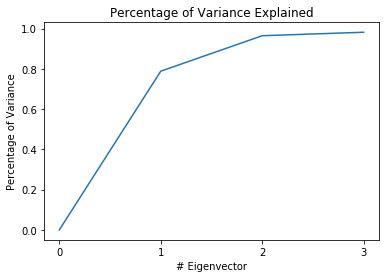

In [41]:
plt.plot(list(range(e_val_contribution[:4].size)),e_val_contribution[:4])
plt.title('Percentage of Variance Explained')
plt.ylabel('Percentage of Variance')
plt.xlabel('# Eigenvector')
plt.xticks(list(range(e_val_contribution[:4].size)),list(range(e_val_contribution[:4].size)))
plt.show()

In [42]:
query="""
SELECT  hour, STDDEV(AEP_MW) AS STDEV_MW_per_hr 
FROM elec_data_ordered_hrs
GROUP BY hour
ORDER BY hour
"""

df_hr_stdev=sqlContext.sql(query)
df_hr_stdev.show(24)
rdd_hr_stdev=df_hr_stdev.rdd.map(lambda row: np.float(row['STDEV_MW_per_hr']))
hour_stdev_array=np.array(rdd_hr_stdev.collect())

+----+------------------+
|hour|   STDEV_MW_per_hr|
+----+------------------+
|  00|1927.6061741580108|
|  01|1900.0821190619693|
|  02|1920.6357760940114|
|  03|1956.7780698399422|
|  04|2006.0570749204626|
|  05|2078.0334826997123|
|  06|  2207.36967592725|
|  07| 2481.570344358184|
|  08|  2576.17619387038|
|  09| 2353.241812405798|
|  10| 2154.593946665252|
|  11|2083.5811457832174|
|  12|2103.6692856143404|
|  13|2200.6740627146055|
|  14|2339.6404540775243|
|  15|2446.8423072075893|
|  16|2513.6712899171735|
|  17| 2539.358263114022|
|  18|2520.4605465933378|
|  19| 2491.946684317429|
|  20| 2328.161858383733|
|  21| 2152.603694826838|
|  22|2105.0642446617644|
|  23|2014.3737179429716|
+----+------------------+



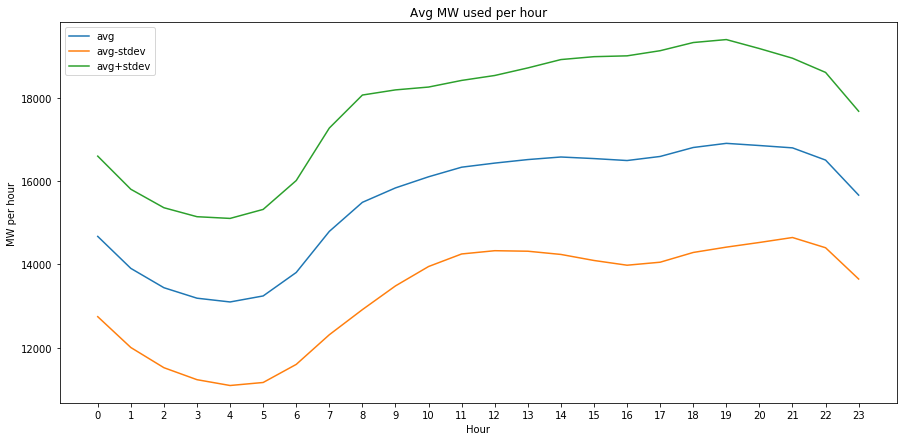

In [43]:
plt.figure(figsize=(15,7))
plt.plot(list(range(hour_avg_array.size)),hour_avg_array, label="avg")
plt.plot(list(range(hour_avg_array.size)),hour_avg_array-hour_stdev_array, label="avg-stdev")
plt.plot(list(range(hour_avg_array.size)),hour_avg_array+hour_stdev_array, label="avg+stdev")
plt.title('Avg MW used per hour')
plt.ylabel('MW per hour')
plt.xlabel('Hour')
plt.xticks(list(range(hour_avg_array.size)),list(range(hour_avg_array.size)))
plt.legend()
plt.show()

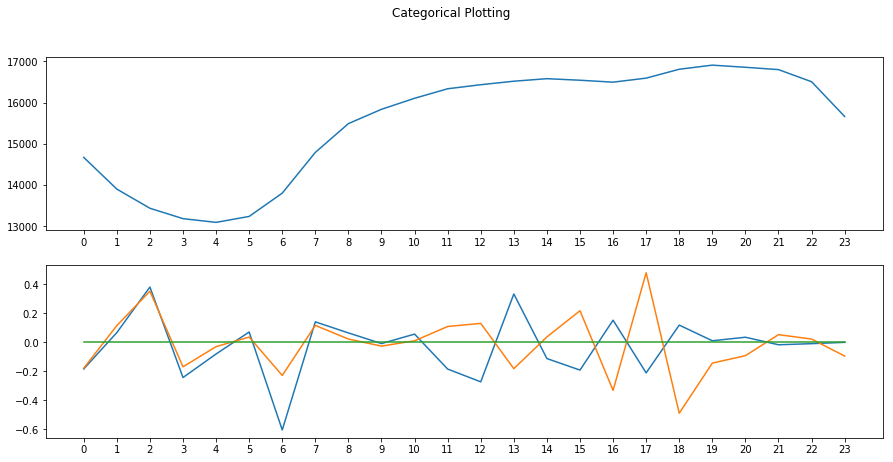

In [44]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(list(range(hour_avg_array.size)), hour_avg_array)
plt.xticks(list(range(hour_avg_array.size)),list(range(hour_avg_array.size)))
plt.subplot(212)
plt.plot(list(range(hour_avg_array.size)), eigvec[0])
plt.plot(list(range(hour_avg_array.size)), eigvec[1])
plt.plot(list(range(hour_avg_array.size)), np.zeros(24))
plt.xticks(list(range(hour_avg_array.size)),list(range(hour_avg_array.size)))
#plt.plot(list(range(hour_avg_array.size)), eigvec[2])
plt.suptitle('Categorical Plotting')
plt.show()

In [61]:
rdd_MW_daily_array=df_grouped_MW.rdd.map(lambda row: (row['month']+','+row['day']+','+row['year'],row['day_consump']))
#rdd_test_array=df_grouped_MW.rdd.map(lambda row: row['day_consump'][0])
#np.dot(np.transpose(eigvec[:,0:2]),np.array(rdd_test.take(1)[0][1]))
rdd_daily_coef=rdd_MW_daily_array.map(lambda row: (row[0],np.dot(np.array(row[1])-hour_avg_array,eigvec[:,0:2]))) 
rdd_daily_approx=rdd_daily_coef.map(lambda row: (row[0],hour_avg_array+np.dot(eigvec[:,0:2],row[1])))   
rdd_daily_residual=rdd_MW_daily_array.map(lambda row: (row[0],LA.norm(hour_avg_array+ np.dot(eigvec[:,0:2],np.dot(np.array(row[1])-hour_avg_array,eigvec[:,0:2]))-np.array(row[1]))))
print(rdd_daily_residual.take(5))
                                                     
  

[('01,01,2005', 2328.17881068409), ('01,02,2005', 1913.861448674261), ('01,03,2005', 2761.5865578823573), ('01,04,2005', 2046.3959065239087), ('01,05,2005', 1911.0648289173969)]


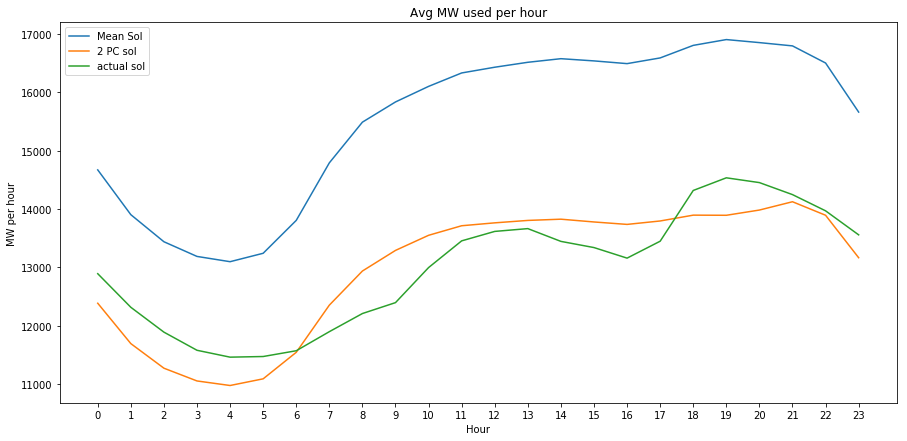

In [52]:
plt.figure(figsize=(15,7))
plt.plot(list(range(hour_avg_array.size)),hour_avg_array, label="Mean Sol")
plt.plot(list(range(hour_avg_array.size)),rdd_daily_approx.take(1)[0][1], label="2 PC sol")
plt.plot(list(range(hour_avg_array.size)),rdd_MW_daily_array.take(1)[0][1], label="actual sol")
plt.title('Avg MW used per hour')
plt.ylabel('MW per hour')
plt.xlabel('Hour')
plt.xticks(list(range(hour_avg_array.size)),list(range(hour_avg_array.size)))
plt.legend()
plt.show()

In [54]:
rdd_daily_residual.take(3)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 248.0 failed 1 times, most recent failure: Lost task 0.0 in stage 248.0 (TID 16385, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 229, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 224, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 372, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/pyspark/rdd.py", line 1354, in takeUpToNumLeft
    yield next(iterator)
  File "<ipython-input-46-e51d1228b247>", line 6, in <lambda>
TypeError: Required argument 'b' (pos 2) not found

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:438)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:421)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$1.apply(PythonRDD.scala:141)
	at org.apache.spark.api.python.PythonRDD$$anonfun$1.apply(PythonRDD.scala:141)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1587)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1586)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1586)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1820)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1769)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1758)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2027)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2048)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2067)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:141)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 229, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 224, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 372, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/pyspark/rdd.py", line 1354, in takeUpToNumLeft
    yield next(iterator)
  File "<ipython-input-46-e51d1228b247>", line 6, in <lambda>
TypeError: Required argument 'b' (pos 2) not found

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:438)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:421)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$1.apply(PythonRDD.scala:141)
	at org.apache.spark.api.python.PythonRDD$$anonfun$1.apply(PythonRDD.scala:141)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
